In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from operator import itemgetter

sys.path.append('F:/time_step/OfflineRL_FactoredActions')
from RL_mimic_sepsis.utils.timestep_util import (
    action_space_global,
    timestep_list, 
    action_space_list,
    action_space_name_mapping,
    )

# Configurations.
version_list = list(range(40))
seed_list = [0, 1, 2, 3, 4]
threshold_list  = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 0.9999]

# Font configurations.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"]  = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "stix"  
plt.rcParams.update({
    "font.size":          14,   
    "axes.titlesize":     15,   
    "axes.labelsize":     14,   
    "xtick.labelsize":    12,   
    "ytick.labelsize":    12,   
    "legend.fontsize":    12,  
    "figure.titlesize":   5,  
    })

print(matplotlib.get_cachedir())

def extract_param_from_yaml(path, key):
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith(f"{key}:"):
                _, raw = line.split(':', 1)
                raw = raw.strip()
                try:
                    if '.' in raw or 'e' in raw.lower():
                        num = float(raw)
                        if num.is_integer():
                            num = int(num)
                        return num
                    else:
                        return int(raw)
                except ValueError:
                    return raw
    raise KeyError(f"{key} not found in {path}")

def pareto2d(data):
    # data: list of (x, y) pairs; returns indices of Pareto‐optimal points
    sorted_data = sorted(enumerate(data), key=lambda x: (x[1][0], x[1][1]), reverse=True)
    pareto_idx = []
    cutoff = -np.inf
    for idx, (_, (_, y)) in enumerate(sorted_data):
        if idx == 0 or y > cutoff:
            pareto_idx.append(sorted_data[idx][0])
            cutoff = y
    return pareto_idx



C:\Users\sunyingchuan\.matplotlib


[t=1h] best with ESS>=50 -> ESS=55.5946, WIS=90.1773, tau=0.5, seed=1, iter=600
[t=2h] best with ESS>=100 -> ESS=104.3268, WIS=91.8410, tau=0.5, seed=1, iter=200
[t=4h] best with ESS>=150 -> ESS=159.8254, WIS=94.0218, tau=0.75, seed=4, iter=8300
[t=8h] best with ESS>=250 -> ESS=300.6269, WIS=96.6350, tau=0.5, seed=2, iter=500


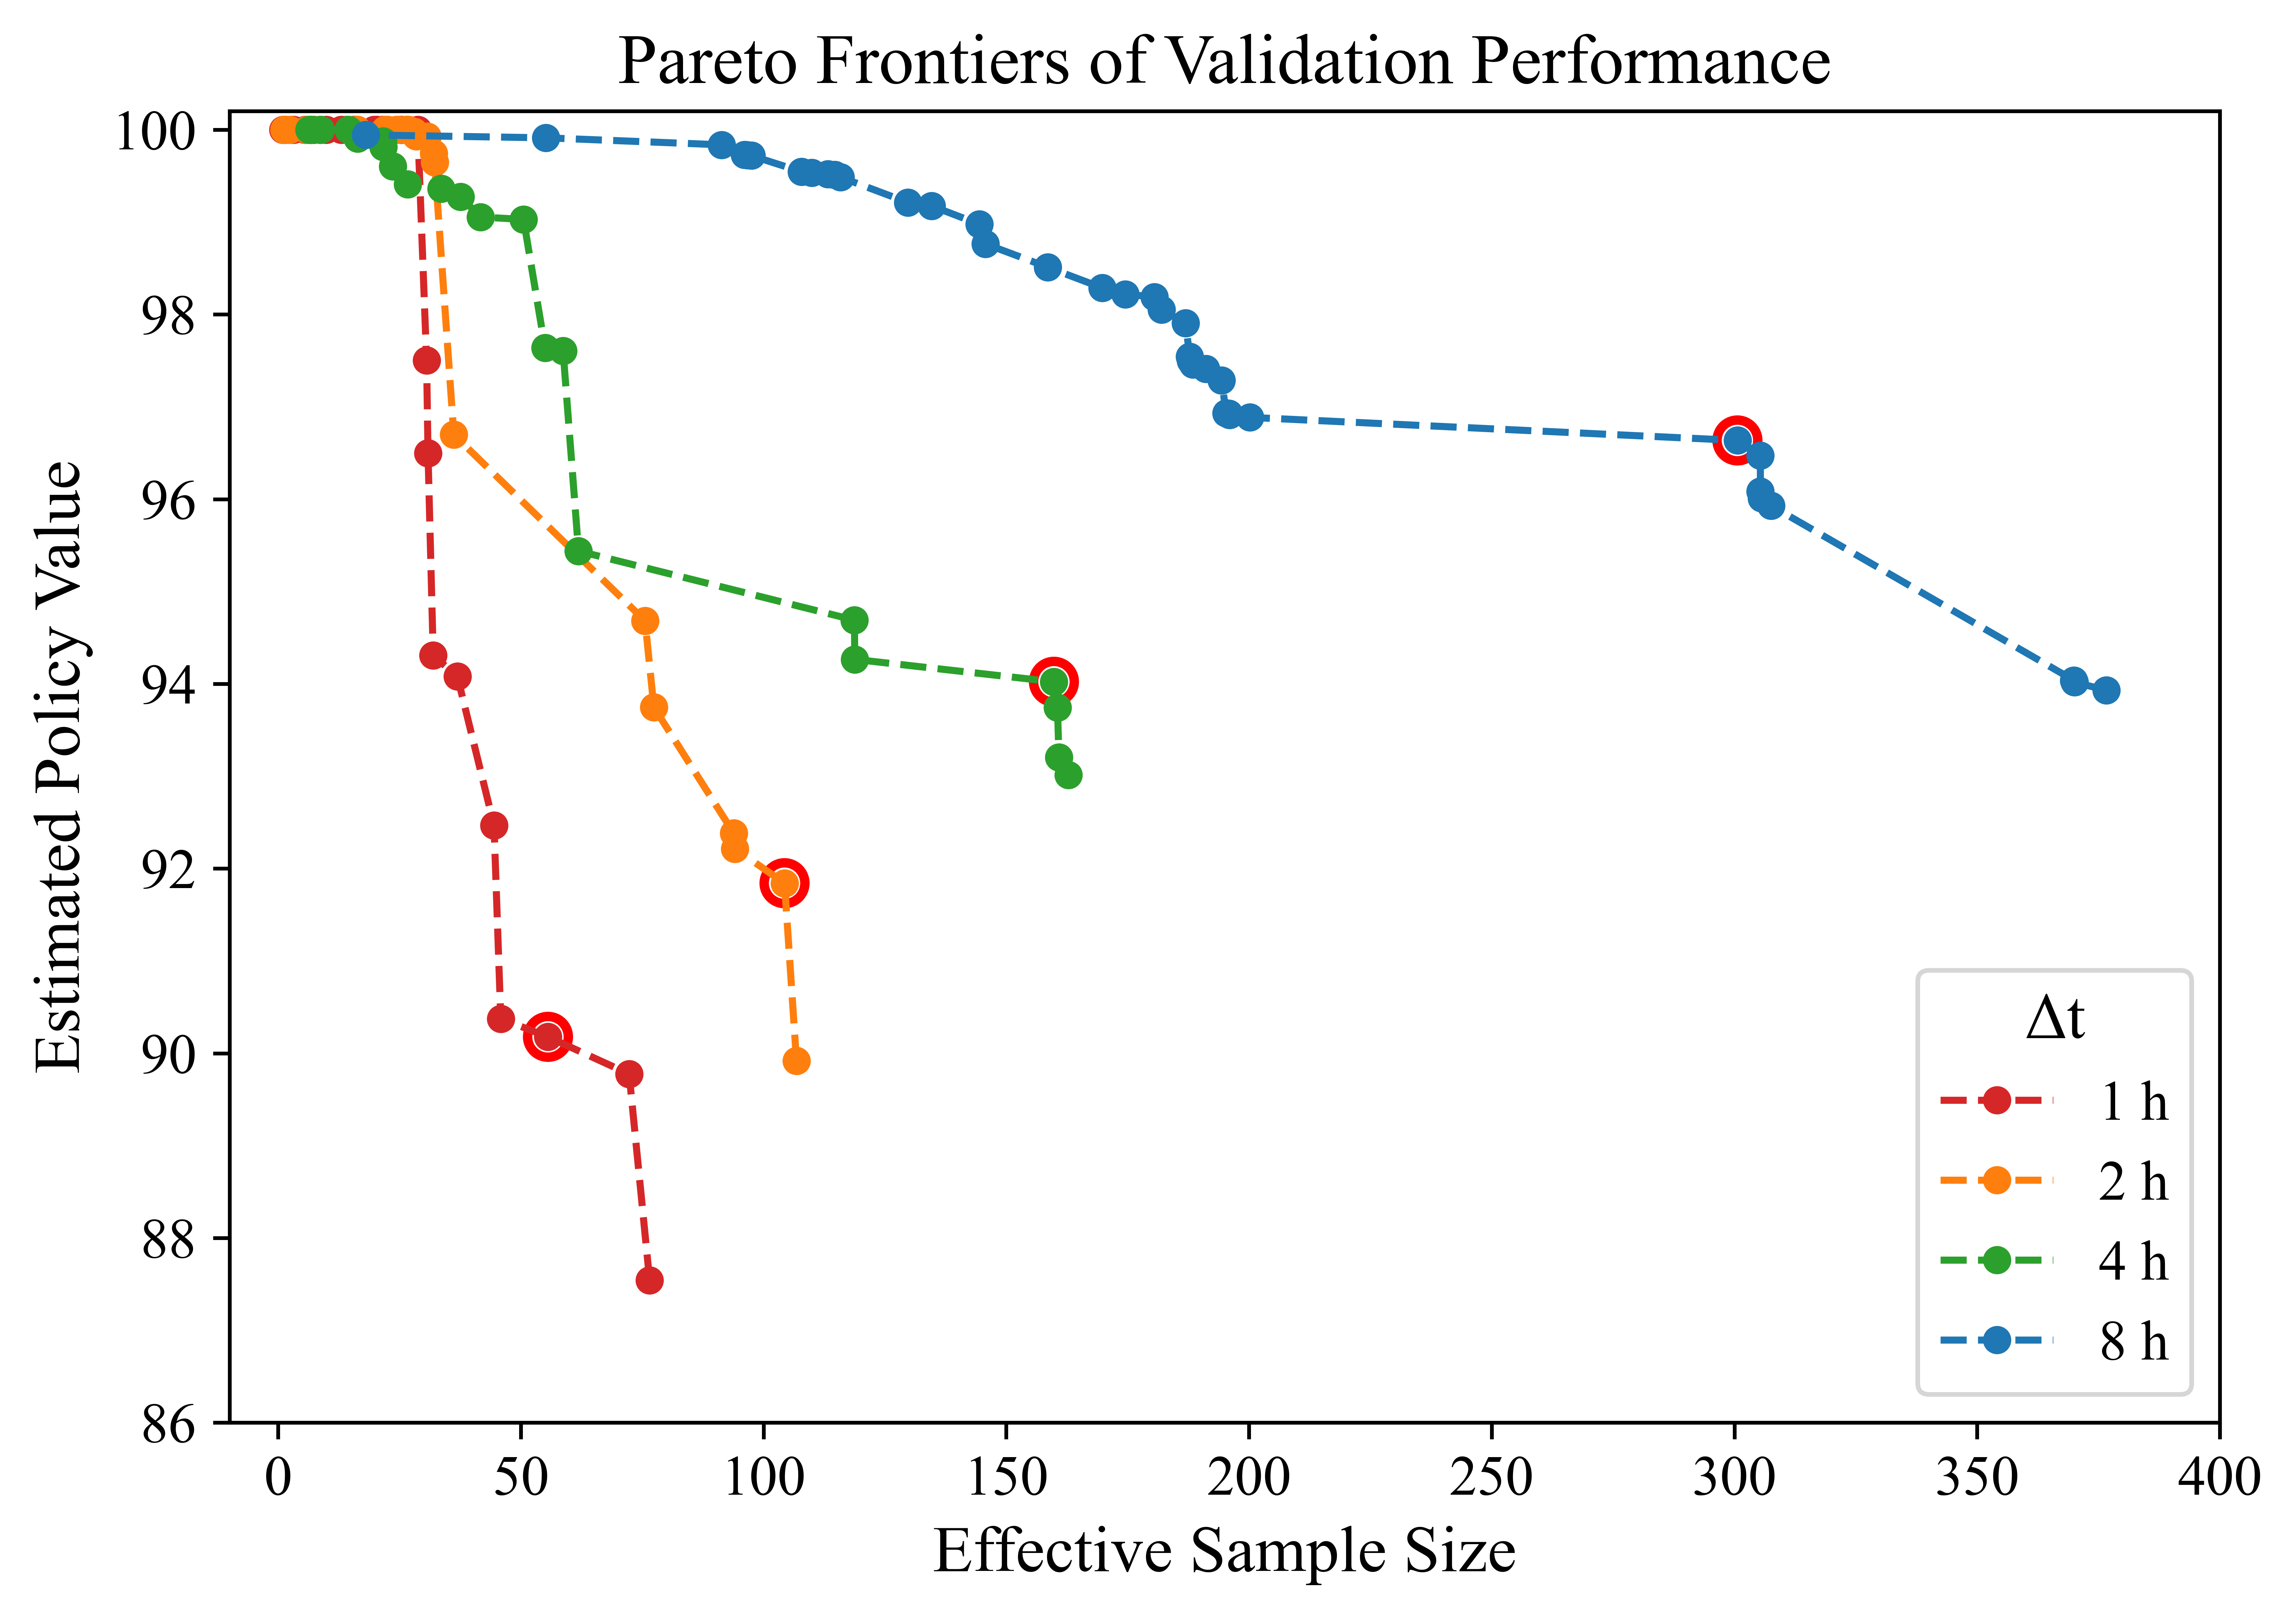

In [ ]:
"""The cell generates the pareto frontier figure for a given action space.
Change: 1. action_space 2.metrics_name 3.clipping method

"""

# Config area.
action_space = 'NormThreshold'
metrics_name = 'metrics_100multiple_eps0.1.csv' # 'metrics_100multiple_eps0.1.csv'
clipping_method = 'PerStepClipping=1.438'
exp_name = 'BCQ_rebuttal'
save = False
# ESS_cutoff = 100


colors_ts = {
    1: 'tab:red',
    2: 'tab:orange',
    4: 'tab:green',
    8: 'tab:blue',
}

# ensure output directory exists
os.makedirs(f'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/figs/{action_space}_pareto', exist_ok=True)

# Store the selected points.
best_points = []

plt.figure(figsize=(7, 5), dpi=1000)

for timestep in timestep_list:
    folder_name = f'BCQ_as{action_space}_dt{timestep}h_grid'
    dfs = []
    for threshold in threshold_list:
        for seed in seed_list:
            csv_path = (
                f'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/'
                f'd_BCQ/logs/{exp_name}/{folder_name}/dt{timestep}_threshold{threshold}seed{seed}/{metrics_name}'
            )

            try:
                df = pd.read_csv(csv_path).iloc[:100]
                df['threshold'] = threshold 
                df['seed'] = seed
                dfs.append(df)
            except Exception as e:
                print(f"[t={timestep}h] Skipping {timestep}h, threshold = {threshold}: {e}")
                continue

    if not dfs:
        print(f"[t={timestep}h] No successful runs—skipping plotting.")
        continue

    df_all = pd.concat(dfs, ignore_index=True)
    df_sorted = df_all.sort_values(by=['val_wis', 'val_ess'], ascending=False)
    # df_sorted = df_sorted[df_sorted['iteration'] > 1000]  # Ensure iteration > 1000
    pts = df_sorted[['val_ess', 'val_wis']].values.tolist()
    pareto_idx = pareto2d(pts)

    plt.plot(
        df_sorted.iloc[pareto_idx]['val_ess'],
        df_sorted.iloc[pareto_idx]['val_wis'],
        ls='--',
        lw=1.5,
        marker='o',
        ms=5,
        c=colors_ts[timestep],
        label=f'{timestep} h'
    )

    # Select the best point with ESS >= ESS_cutoff.
    ESS_cutoff = {1: 50, 2: 100, 4: 150, 8: 250}[timestep]  # Adjusted ESS cutoff based on timestep
    ok = df_all[df_all['val_ess'] >= ESS_cutoff]
    # ok = ok[ok['iteration'] > 1000]  # Ensure iteration > 1000
    if len(ok) > 0:
        best = ok.loc[ok['val_wis'].idxmax()]
        best_points.append(
            {
                'timestep': timestep,
                'val_ess': float(best['val_ess']),
                'val_wis': float(best['val_wis']),
                'threshold': float(best['threshold']),
                'seed': int(best['seed']),
                'iteration': int(best['iteration']),
            }
        )
        print(
            f"[t={timestep}h] best with ESS>={ESS_cutoff} -> "
            f"ESS={best['val_ess']:.4f}, WIS={best['val_wis']:.4f}, "
            f"tau={best['threshold']}, seed={int(best['seed'])}"
            f", iter={int(best['iteration'])}"
        )
        # plt.axvline(ESS_cutoff, ls=':', lw=1, c=colors_ts[timestep])
    else:
        print(f"[t={timestep}h] No points with ESS >= 200.")

# Plot best points for each time step.
x = [p['val_ess'] for p in best_points]
y = [p['val_wis'] for p in best_points]
plt.scatter(x, y, edgecolor='r', facecolor='none', s=75, lw=2)

# Edge of ESS model selection.

plt.xlabel('Effective Sample Size')
plt.ylabel('Estimated Policy Value')

plt.xlim(-10, 400)
plt.ylim(86, 100.2)

# action_space_name = action_space_name_mapping[action_space]

# Comment this out for paper's figure.
# plt.title(f'Pareto Frontiers of Validation Performance - {action_space} - {clipping_method}')
plt.title(f'Pareto Frontiers of Validation Performance')

plt.legend(title='Δt', loc='lower right')
plt.tight_layout()
if save:
    plt.savefig(f'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/'
                f'd_BCQ/figs/{action_space}_pareto/par_as{action_space}_clip{clipping_method}.pdf', dpi=1000)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/logs/bcq_asNormThreshold_dt1h_grid/version_0/metrics_new.csv'

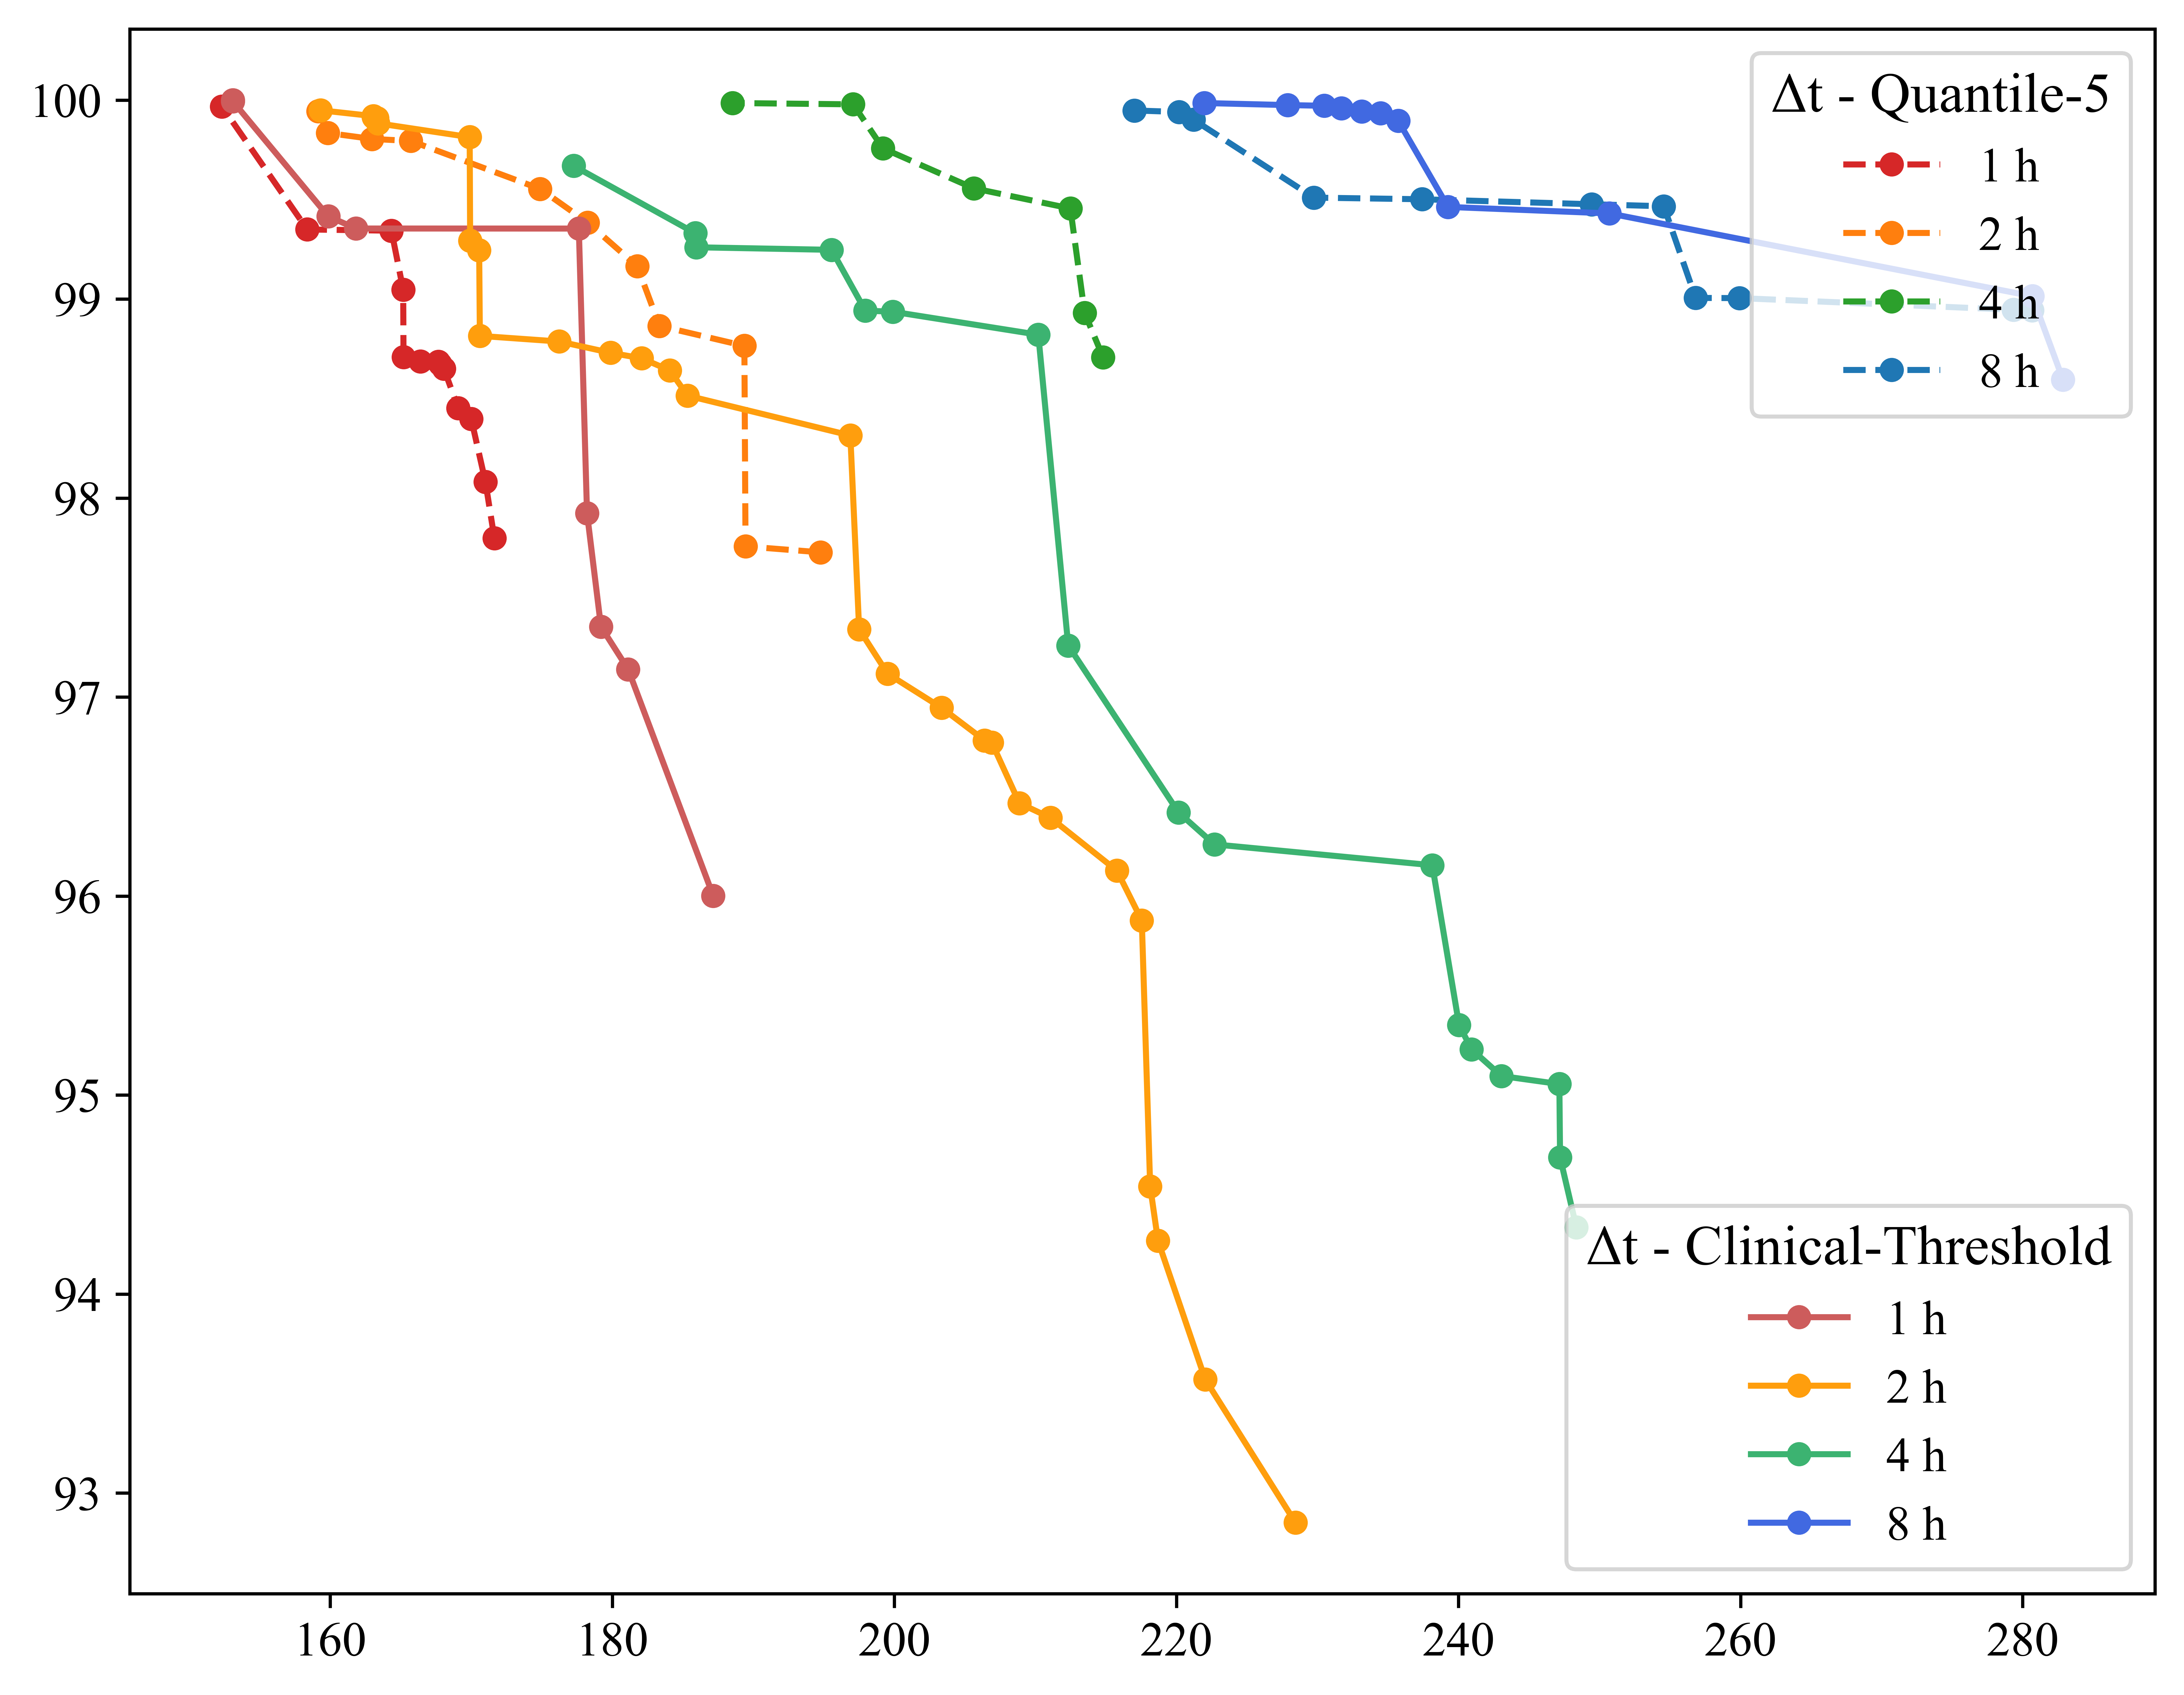

In [ ]:
"""This cell creates the pareto frontier figure for both action space.
They are Quantile-5 and Clinical-Threshold. The dashed lines(--) are for Quantile-5,
and the solid lines(-) are for Clinical-Threshold.
"""

# Configuartions.
metric_name = 'metrics_new.csv'
clipping_method_list = {1: '95% Clipping', 2: 'Clipping Threshold = 1000'}
clipping_method = clipping_method_list[1]


colors_quantile = {1: 'tab:red', 2: 'tab:orange', 4: 'tab:green', 8: 'tab:blue'}
colors_threshold = {1: "#cd5c5c", 2: "#ff9e0d", 4: "#3cb371", 8: "#4169e1"}

fig, ax = plt.subplots(figsize=(9, 7), dpi=1000)

quantile_handles = []
threshold_handles = []
timestep_labels = [f"{t} h" for t in timestep_list]


os.makedirs(f'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/fig/'
            f'{action_space_global}pareto', exist_ok=True)


for action_space in action_space_list:
    for timestep in timestep_list:
        folder_name = f'bcq_as{action_space}_dt{timestep}h_grid'

        dfs = [
            pd.read_csv('F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/logs/'
                        f'{folder_name}/version_{i}/{metric_name}').iloc[:100]
            for i in version_list
        ]
        df_all = pd.concat(dfs, ignore_index=True)
        df_sorted = df_all.sort_values(by=['val_wis', 'val_ess'], ascending=False)
        pts = df_sorted[['val_ess', 'val_wis']].values.tolist()
        pareto_idx = pareto2d(pts)

        line, = ax.plot(
            df_sorted.iloc[pareto_idx]['val_ess'],
            df_sorted.iloc[pareto_idx]['val_wis'],
            ls='--' if action_space == 'Quantile' else '-',
            lw=1.5,
            marker='o',
            ms=5,
            c=colors_quantile[timestep] if action_space == 'Quantile' else colors_threshold[timestep]
        )

        if action_space=='Quantile':
            quantile_handles.append(line)
        else:
            threshold_handles.append(line)

    # Creates different legends for action spaces.
    if action_space == 'Quantile':
        legend_quantile = ax.legend(quantile_handles, timestep_labels,
                                    title=f'Δt - {action_space_name_mapping[action_space]}',
                                    loc='upper right')
        ax.add_artist(legend_quantile)
    else:
        legend_threshold = ax.legend(threshold_handles, timestep_labels,
                                    title=f'Δt - {action_space_name_mapping[action_space]}',
                                    loc='lower right')

        

plt.xlabel('Effective Sample Size')
plt.ylabel('Estimated Policy Value')

# NOTE: Set xlim(140, 300) and ylim(92, 100.5) are suitable for comparing 95% clipping, and
# NOTE: Set xlim(-10, 700) and ylim(92, 100.5) are suitable for comparing 1000 threshold clipping.
plt.xlim(0, 700)
plt.ylim(92, 100.5)

plt.title(f'Pareto Frontiers of Validation Performance - {clipping_method}')

plt.tight_layout()
# plt.savefig(f'./fig/{action_space_global}_pareto/par_new_v2.pdf')
plt.show()

In [ ]:
"""This cell creates the pareto frontier figure across different clpping methods.
"""

# Configuartions.
action_space = action_space_list[1]

metric_name_mapping = {1: 'metrics.csv', 2: 'metrics_new.csv'}
clipping_method_mapping = {1: '95% Clipping', 2: 'Clipping Threshold = 1000'}

colors_thre1000 = {1: 'tab:red', 2: 'tab:orange', 4: 'tab:green', 8: 'tab:blue'}
colors_p95 = {1: "#cd5c5c", 2: "#ff9e0d", 4: "#3cb371", 8: "#4169e1"}

fig, ax = plt.subplots(figsize=(9, 7), dpi=1000)

thre1000_handles = []
p95_handles = []
timestep_labels = [f"{t} h" for t in timestep_list]


os.makedirs(f'F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/fig/'
            f'{action_space_global}pareto', exist_ok=True)

for metric_name in metric_name_mapping.values():
    for timestep in timestep_list:
        folder_name = f'bcq_as{action_space}_dt{timestep}h_grid'

        dfs = [
            pd.read_csv('F:/time_step/OfflineRL_FactoredActions/RL_mimic_sepsis/d_BCQ/logs/'
                        f'{folder_name}/version_{i}/{metric_name}').iloc[:100]
            for i in version_list
        ]
        df_all = pd.concat(dfs, ignore_index=True)
        df_sorted = df_all.sort_values(by=['val_wis', 'val_ess'], ascending=False)
        pts = df_sorted[['val_ess', 'val_wis']].values.tolist()
        pareto_idx = pareto2d(pts)

        line, = ax.plot(
            df_sorted.iloc[pareto_idx]['val_ess'],
            df_sorted.iloc[pareto_idx]['val_wis'],
            ls='--' if metric_name == 'metrics.csv' else '-',
            lw=1.5,
            marker='o',
            ms=5,
            c=colors_thre1000[timestep] if metric_name == 'metrics.csv' else colors_p95[timestep]
        )

        if metric_name == 'metrics.csv':
            thre1000_handles.append(line)
        else:
            p95_handles.append(line)

    # Creates different legends for action spaces.
    if metric_name == 'metrics.csv':
        legend_quantile = ax.legend(thre1000_handles, timestep_labels,
                                    title=f'Δt - {clipping_method_mapping[2]}',
                                    loc='upper right')
        ax.add_artist(legend_quantile)
    else:
        legend_threshold = ax.legend(p95_handles, timestep_labels,
                                    title=f'Δt - {clipping_method_mapping[1]}',
                                    loc='lower right')

        

plt.xlabel('Effective Sample Size')
plt.ylabel('Estimated Policy Value')

# NOTE: Set xlim(-10, 450) and ylim(92, 100.5) are suitable for comparing Quantile-5, and
# NOTE: Set xlim(-10, 700) and ylim(92, 100.5) are suitable for comparing 1000 threshold clipping.
plt.xlim(-10, 700)
plt.ylim(92, 100.5)

plt.title(f'Pareto Frontiers of Validation Performance - {action_space_name_mapping[action_space]}')

plt.tight_layout()
# plt.savefig(f'./fig/{action_space_global}_pareto/par_new_v2.pdf')
plt.show()